In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import keras as K
from keras import callbacks, optimizers
from keras import backend as KB
from keras.engine import Layer
from keras.layers import Activation
from keras.layers import LeakyReLU, Dense, Input, Embedding, Dropout, Reshape
from keras.layers import Bidirectional, GRU, Flatten, SpatialDropout1D, Conv1D
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Model
from keras.utils import to_categorical
from common import vocabulary, utils

Using TensorFlow backend.


In [2]:
print("Tensorflow version:", tf.__version__)
print("Keras version:", K.__version__)

Tensorflow version: 1.6.0
Keras version: 2.1.5


## Load the dataset

### First attempt
x_train: sentence - list of words  
y_train: sentence - list of NER tag

### Second attempt (maybe?)
x_train: sentence - list of words, POS tags  
y_train: sentence - list of NER tags

### Notes
> Does it makes sense to use 'O' as the padding for the NER tags? Should we use something else?
> - Currently, I am using `<s>` and `</s>`  

> perhaps we want to try without the I-, B- modifiers


In [3]:
TRAIN_FILE = "./data/conll2003/eng.train"
DEV_FILE = "./data/conll2003/eng.testa"
TEST_FILE = "./data/conll2003/eng.testb"

In [4]:
!head -10 {TRAIN_FILE}

-DOCSTART- -X- -X- O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [5]:
# this is odd that the B-PER tag doesn't appear... investigate this.
!grep "B-PER" {TRAIN_FILE}

In [6]:
def readfile( filename, pos=False):
    '''
    read the conll2003 file
    
    filename(string) - path to conll2003 file (train, test, etc.)
    pos(boolean) - flag if true will include pos tags in returned list
    returns a list of lists of lists corresponding to the words in each sentence
    
    '''
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.strip().split(' ')
        word = [splits[0], splits[1], splits[-1]] if pos else [splits[0], splits[-1]]
        sentence.append( word)

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

In [7]:
trainSentences = readfile(TRAIN_FILE, True)

In [8]:
for i in range(0, 4):
    print(trainSentences[i])

[['EU', 'NNP', 'I-ORG'], ['rejects', 'VBZ', 'O'], ['German', 'JJ', 'I-MISC'], ['call', 'NN', 'O'], ['to', 'TO', 'O'], ['boycott', 'VB', 'O'], ['British', 'JJ', 'I-MISC'], ['lamb', 'NN', 'O'], ['.', '.', 'O']]
[['Peter', 'NNP', 'I-PER'], ['Blackburn', 'NNP', 'I-PER']]
[['BRUSSELS', 'NNP', 'I-LOC'], ['1996-08-22', 'CD', 'O']]
[['The', 'DT', 'O'], ['European', 'NNP', 'I-ORG'], ['Commission', 'NNP', 'I-ORG'], ['said', 'VBD', 'O'], ['on', 'IN', 'O'], ['Thursday', 'NNP', 'O'], ['it', 'PRP', 'O'], ['disagreed', 'VBD', 'O'], ['with', 'IN', 'O'], ['German', 'JJ', 'I-MISC'], ['advice', 'NN', 'O'], ['to', 'TO', 'O'], ['consumers', 'NNS', 'O'], ['to', 'TO', 'O'], ['shun', 'VB', 'O'], ['British', 'JJ', 'I-MISC'], ['lamb', 'NN', 'O'], ['until', 'IN', 'O'], ['scientists', 'NNS', 'O'], ['determine', 'VBP', 'O'], ['whether', 'IN', 'O'], ['mad', 'JJ', 'O'], ['cow', 'NN', 'O'], ['disease', 'NN', 'O'], ['can', 'MD', 'O'], ['be', 'VB', 'O'], ['transmitted', 'VBN', 'O'], ['to', 'TO', 'O'], ['sheep', 'NN', '

## Determine the max sentence length
> Let's start by clipping the longest 5%  
> This will probably change, but we've got to start somewhere.

In [9]:
trainLens = np.array([ len(s) for s in trainSentences])

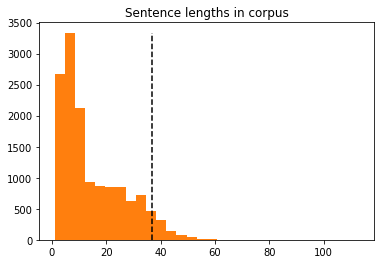

Sentences longer than 37.0 words: 5 %


In [10]:
from matplotlib import pyplot as plt
clipPct = 5

maxLen = np.percentile(trainLens, 100 - clipPct)
histLens = plt.hist(trainLens, bins=30)
plt.vlines( maxLen, 0, max(histLens[0]), linestyles="dashed")
plt.title("Sentence lengths in corpus")
plt.hist(trainLens, bins=30)
plt.show()
print( "Sentences longer than", maxLen, "words:", clipPct, "%")

In [11]:
print(histLens)
print( "Max sentence length: ", max(trainLens))

(array([  2.66500000e+03,   3.33600000e+03,   2.12800000e+03,
         9.26000000e+02,   8.61000000e+02,   8.54000000e+02,
         8.58000000e+02,   6.27000000e+02,   7.23000000e+02,
         4.59000000e+02,   3.25000000e+02,   1.37000000e+02,
         7.90000000e+01,   3.90000000e+01,   1.00000000e+01,
         9.00000000e+00,   2.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.00000000e+00]), array([   1.        ,    4.73333333,    8.46666667,   12.2       ,
         15.93333333,   19.66666667,   23.4       ,   27.13333333,
         30.86666667,   34.6       ,   38.33333333,   42.06666667,
         45.8       ,   49.53333333,   53.26666667,   57.        ,
         60.73333333,   64.46666667,   68.2       ,   71.93333333,
         75.66666667,   79.4       ,   83.13333333, 

In [12]:
trainSentences[:5]

[[['EU', 'NNP', 'I-ORG'],
  ['rejects', 'VBZ', 'O'],
  ['German', 'JJ', 'I-MISC'],
  ['call', 'NN', 'O'],
  ['to', 'TO', 'O'],
  ['boycott', 'VB', 'O'],
  ['British', 'JJ', 'I-MISC'],
  ['lamb', 'NN', 'O'],
  ['.', '.', 'O']],
 [['Peter', 'NNP', 'I-PER'], ['Blackburn', 'NNP', 'I-PER']],
 [['BRUSSELS', 'NNP', 'I-LOC'], ['1996-08-22', 'CD', 'O']],
 [['The', 'DT', 'O'],
  ['European', 'NNP', 'I-ORG'],
  ['Commission', 'NNP', 'I-ORG'],
  ['said', 'VBD', 'O'],
  ['on', 'IN', 'O'],
  ['Thursday', 'NNP', 'O'],
  ['it', 'PRP', 'O'],
  ['disagreed', 'VBD', 'O'],
  ['with', 'IN', 'O'],
  ['German', 'JJ', 'I-MISC'],
  ['advice', 'NN', 'O'],
  ['to', 'TO', 'O'],
  ['consumers', 'NNS', 'O'],
  ['to', 'TO', 'O'],
  ['shun', 'VB', 'O'],
  ['British', 'JJ', 'I-MISC'],
  ['lamb', 'NN', 'O'],
  ['until', 'IN', 'O'],
  ['scientists', 'NNS', 'O'],
  ['determine', 'VBP', 'O'],
  ['whether', 'IN', 'O'],
  ['mad', 'JJ', 'O'],
  ['cow', 'NN', 'O'],
  ['disease', 'NN', 'O'],
  ['can', 'MD', 'O'],
  ['be', 'VB'

In [13]:
# build vocabulary - thank you w266
# -- first attempt, leave in all numbers and maintain case
flatData = [w for w in zip(*utils.flatten(trainSentences))]

# try with lower vocab sizes... 10k, 15k, 20k
vocab = vocabulary.Vocabulary( flatData[0])
posTags = vocabulary.Vocabulary( flatData[1])
nerTags = vocabulary.Vocabulary( flatData[2])

print( (list(vocab.wordset)[:20]))
print( "Vocab size:", vocab.size)
print( (list(posTags.wordset)))
print( (list(nerTags.wordset)))

['Caucasus', 'association', '1.84', '37,000', 'acknowledge', '2,096.10', 'battling', 'LIMITS', 'FI', 'DAILY', '543', 'Dai', '462', 'Asprilla', 'noise', 'Jacek', 'abstentions', 'Bodo', 'horseback', 'Available']
Vocab size: 23626
['SYM', 'PDT', 'RP', '"', 'NN', 'DT', 'JJ', "''", '.', 'NN|SYM', 'WP$', 'UH', 'PRP', 'NNS', 'TO', 'VBG', 'WRB', 'VB', 'FW', 'RB', 'VBN', '<s>', 'RBR', ':', 'JJS', '</s>', '<unk>', 'NNP', 'RBS', ')', 'VBZ', 'NNPS', 'LS', 'CD', 'EX', 'MD', '$', ',', 'IN', 'POS', 'VBD', 'WDT', 'CC', 'JJR', 'VBP', 'WP', '(', 'PRP$']
['I-PER', 'B-MISC', '</s>', '<unk>', 'I-MISC', 'I-ORG', 'B-ORG', 'I-LOC', 'B-LOC', '<s>', 'O']


### This might be a good place to do some EDA on the vocab objects...



## Done playing around, define the data class

In [14]:
class conll2003Data(object):
    """
    Keep track of data and processing operations for a single CoNLL2003 data file.
    """
    
    def __init__(self, filePath):
        """
        filePath(string): path to a CoNLL2003 raw data file for training the vocabulary
        """
        # vocabulary objects for easy lookup
        self.vocab = []
        self.posTags = []
        self.nerTags = []
        
        # read in training data
        self.sentences = self.readFile(filePath)
        
    
    def readFile( self, filePath):
        """
        Read the conll2003 raw data file

        filename(string) - path to conll2003 file (train, test, etc.)
        
        Returns: a list of lists of lists corresponding to the words, pos tags, and ner tags
                 in each sentence

        """
        f = open(filePath)
        sentences = []
        sentence = []
        for line in f:
            if len(line) == 0 or line.startswith("-DOCSTART") or line[0] == '\n':
                if len(sentence) > 0:
                    sentences.append(sentence)
                    sentence = []
                continue
            
            # input format is [ word, pos tag, chunck tag, ner tag]
            # we are ignoring the chunck tag
            splits = line.strip().split(' ')
            word = [splits[0], splits[1], splits[3]]
            sentence.append( word)
        
        # don't forget the last one
        if len(sentence) > 0:
            sentences.append(sentence)
            sentence = []
        
        return sentences
    
    def buildVocab( self, vocabSize=None, verbose=False):
        """
        Builds the vocabulary based on the initial data file
        
        vocabSize(int, default: None-all words) - max number of words to use for vocabulary
                                                  (only used for training)
        verbose(boolean, default: False)        - print extra info
        """
        
        
        flatData = [w for w in zip(*utils.flatten(self.sentences))]
        self.vocab = vocabulary.Vocabulary( flatData[0], size=vocabSize)
        
        # remember these vocabs will have the <s>, </s>, and <unk> tags in there
        # sizes need to be interpreted "-3" - consider replacing...
        self.posTags = vocabulary.Vocabulary( flatData[1])
        self.nerTags = vocabulary.Vocabulary( flatData[2])
        
        if verbose is True:
            print( list(self.vocab.wordset)[:5], "\n")
            print( list(self.posTags.wordset)[:5], "\n")
            print( list(self.nerTags.wordset)[:5], "\n")
    
    def formatPaddedData( self, sentences, clipPct = 5, verbose=False):
        """
        Format the raw data by padding up to a max sentence length to be usable for training.
        Make sure to call buildVocab first.
        
        sentences(list of lists of lists) - raw data from the CoNLL2003 dataset
        clipPct(int, default: 5)          - the percentage of sentences to clip when determining the
                                            max length to allow
        verbose(boolean, default: False)  - print extra info
        
        Returns: 3 lists:   vocabulary converted to IDs, 
                            POS tags converted to IDs,
                            NER label tag converted to IDs
        """
        # get the maximum sentence length to clip down to (and pad up to) (add 2 for <s> and </s>)
        self.maxSentLen = int(np.percentile( np.array([ len(s) for s in self.sentences]), 100.0 - clipPct)) + 2
        
        # we have a list of lists (sentences) of lists ([word, posTag, nerTag])
        # parse through, pad each sentence with open and close tags, then convert to IDs
        vocabIDs = [ self.vocab.words_to_ids( self.vocab.pad_sentence([ word[0] for word in sent])) \
                     for sent in sentences]
        posIDs = [ self.posTags.words_to_ids( self.posTags.pad_sentence([word[1] for word in sent])) \
                   for sent in sentences]
        nerIDs = [ self.nerTags.words_to_ids( ['<s>'] + [word[2] for word in sent] + ['</s>']) \
                   for sent in sentences]
        
        if verbose is True:
            print( vocabIDs[:5], "\n")
            print( posIDs[:5], "\n")
            print( nerIDs[:5], "\n")

        # pad and clip so all sentences are the same length
        vocabIDs = sequence.pad_sequences( vocabIDs, maxlen = self.maxSentLen)
        posIDs = sequence.pad_sequences( posIDs, maxlen = self.maxSentLen)
        nerIDs = sequence.pad_sequences( nerIDs, maxlen = self.maxSentLen, 
                                         value=self.nerTags.word_to_id['O'])
        
        return vocabIDs, posIDs, nerIDs
    
    #
    # I think it makes the most sense to generate all the training data up front.
    # If we had more data or planned to augment on the fly, it would make more sense to 
    # use a generator.
    # 
    # window generation notes
    #     Don't cross sentence boundaries.
    #     This means that each sentence will be padded with (windowLength // 2) open/close
    #     tags on each end. Also, when we hit a <s> tag after a </s> tag, start the new
    #     window there rather than continuing to slide.
    # 
    def formatWindowedData( self, sentences, windowLength=9, verbose=False):
        """
        Format the raw data by blocking it into context windows of a fixed length corresponding 
        to the single target NER tag of the central word.
        Make sure to call buildVocab first.
        
        sentences(list of lists of lists) - raw data from the CoNLL2003 dataset
        windowLength(int, default: 9)     - The length of the context window
                    NOTE - windowLength must be odd to have a central word. If itsn't, 1 will be added.
        verbose(boolean, default: False)  - print extra info
        
        Returns: 3 numpy arrays: vocabulary training data windowed and converted to IDs, 
                                 POS tags windowed and converted to IDs,
                                 NER label tags converted to IDs
        """
        pads = windowLength // 2
        
        # we have a list of lists (sentences) of lists ([word, posTag, nerTag])
        # parse through, pad each sentence with pads open and close tags, then convert to IDs
        vocabIDs = [ self.vocab.words_to_ids( ["<s>"] * pads + [word[0] for word in sent] + ["</s>"] * pads) \
                     for sent in sentences]
        posIDs = [ self.posTags.words_to_ids( ["<s>"] * pads + [word[1] for word in sent] + ["</s>"] * pads) \
                   for sent in sentences]
        nerIDs = [ self.nerTags.words_to_ids( ["<s>"] * pads + [word[2] for word in sent] + ["</s>"] * pads) \
                   for sent in sentences]
        
        if verbose is True:
            print( vocabIDs[:5], "\n")
            print( posIDs[:5], "\n")
            print( nerIDs[:5], "\n")
        
        assert(len(vocabIDs) == len(posIDs) and len(posIDs) == len(nerIDs))
        
        # build the data to train on by sliding the window across each sentence
        # at this point, all 3 lists are the same size, so we can run through them all at once
        featsVocab, featsPOS, featsNER = [], [], []
        for sentID in range( len(vocabIDs)):
            sent = vocabIDs[sentID]
            sentPOS = posIDs[sentID]
            sentNER = nerIDs[sentID]
            
            for ID in range( len(sent) - windowLength + 1):
                featsVocab.append( sent[ID:ID + windowLength])
                featsPOS.append( sentPOS[ID:ID + windowLength])
                featsNER.append( sentNER[ID + windowLength // 2])
        
        return np.array(featsVocab), \
               np.array(featsPOS), \
               np.array(featsNER)



### Test the windowing functionality

In [15]:
sentences = trainSentences
windowLength = 9
pads = windowLength // 2
verbose = True

In [16]:
# we have a list of lists (sentences) of lists ([word, posTag, nerTag])
# parse through, pad each sentence with open and close tags, then convert to IDs
vocabIDs = [ vocab.words_to_ids( ["<s>"] * pads + [word[0] for word in sent] + ["</s>"] * pads) \
             for sent in sentences]
posIDs = [ posTags.words_to_ids( ["<s>"] * pads + [word[1] for word in sent] + ["</s>"] * pads) \
           for sent in sentences]
nerIDs = [ nerTags.words_to_ids( ["<s>"] * pads + [word[2] for word in sent] + ["</s>"] * pads) \
           for sent in sentences]

if verbose is True:
    print( vocabIDs[:3], "\n")
    print( posIDs[:3], "\n")
    print( nerIDs[:3], "\n")

[[0, 0, 0, 0, 959, 11985, 235, 764, 8, 4149, 211, 6184, 3, 1, 1, 1, 1], [0, 0, 0, 0, 734, 2070, 1, 1, 1, 1], [0, 0, 0, 0, 1381, 136, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 3, 22, 8, 4, 17, 13, 8, 4, 11, 1, 1, 1, 1], [0, 0, 0, 0, 3, 3, 1, 1, 1, 1], [0, 0, 0, 0, 3, 5, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 5, 3, 7, 3, 3, 3, 7, 3, 3, 1, 1, 1, 1], [0, 0, 0, 0, 4, 4, 1, 1, 1, 1], [0, 0, 0, 0, 6, 3, 1, 1, 1, 1]] 



In [17]:
# build the data to train on by sliding the window across each sentence
# at this point, all 3 lists are the same size, so we can run through them all at once
featsVocab, featsPOS, featsNER = [], [], []
for sentID in range( len(vocabIDs)):
    sent = vocabIDs[sentID]
    sentPOS = posIDs[sentID]
    sentNER = nerIDs[sentID]
    for ID in range( len(sent) - windowLength + 1):
        featsVocab.append( sent[ID:ID + windowLength])
        featsPOS.append( sentPOS[ID:ID + windowLength])
        featsNER.append( sentNER[ID + windowLength // 2])

showID = 0
print( vocabIDs[showID])
print( posIDs[showID])
print( nerIDs[showID], '\n')
print( vocabIDs[showID+1])
print( posIDs[showID+1])
print( nerIDs[showID+1])
print( '\n')
for i in range(11):
    print( featsVocab[i])
    print( featsPOS[i])
    print( "Center NER tag:", featsNER[i])
    print( "Center ID:", featsVocab[i][windowLength // 2], '\n')
    

[0, 0, 0, 0, 959, 11985, 235, 764, 8, 4149, 211, 6184, 3, 1, 1, 1, 1]
[0, 0, 0, 0, 3, 22, 8, 4, 17, 13, 8, 4, 11, 1, 1, 1, 1]
[0, 0, 0, 0, 5, 3, 7, 3, 3, 3, 7, 3, 3, 1, 1, 1, 1] 

[0, 0, 0, 0, 734, 2070, 1, 1, 1, 1]
[0, 0, 0, 0, 3, 3, 1, 1, 1, 1]
[0, 0, 0, 0, 4, 4, 1, 1, 1, 1]


[0, 0, 0, 0, 959, 11985, 235, 764, 8]
[0, 0, 0, 0, 3, 22, 8, 4, 17]
Center NER tag: 5
Center ID: 959 

[0, 0, 0, 959, 11985, 235, 764, 8, 4149]
[0, 0, 0, 3, 22, 8, 4, 17, 13]
Center NER tag: 3
Center ID: 11985 

[0, 0, 959, 11985, 235, 764, 8, 4149, 211]
[0, 0, 3, 22, 8, 4, 17, 13, 8]
Center NER tag: 7
Center ID: 235 

[0, 959, 11985, 235, 764, 8, 4149, 211, 6184]
[0, 3, 22, 8, 4, 17, 13, 8, 4]
Center NER tag: 3
Center ID: 764 

[959, 11985, 235, 764, 8, 4149, 211, 6184, 3]
[3, 22, 8, 4, 17, 13, 8, 4, 11]
Center NER tag: 3
Center ID: 8 

[11985, 235, 764, 8, 4149, 211, 6184, 3, 1]
[22, 8, 4, 17, 13, 8, 4, 11, 1]
Center NER tag: 3
Center ID: 4149 

[235, 764, 8, 4149, 211, 6184, 3, 1, 1]
[8, 4, 17, 13, 8, 4, 11,

## Load the data

In [18]:
#clipPct = 5
windowLength = 9
testNumSents = 5000

# read in training data
vocabData = conll2003Data( TRAIN_FILE)

# FOR TESTING
#vocabData.sentences = vocabData.sentences[:testNumSents]

# not yet using the pos tags
# try with lower vocab sizes... 10k, 15k, 20k
#vocabData.buildVocab( vocabSize=20000)
vocabData.buildVocab( vocabSize=20000)
trainX, _, trainY = vocabData.formatWindowedData( vocabData.sentences, 
                                                  windowLength=windowLength,
                                                  verbose=True)

# check the first few windows
print( "Windowed sentence length:", len(trainX[0]))
print( trainX[:10], '\n', trainY[:10])

[[0, 0, 0, 0, 959, 11985, 235, 764, 8, 4149, 211, 6184, 3, 1, 1, 1, 1], [0, 0, 0, 0, 734, 2070, 1, 1, 1, 1], [0, 0, 0, 0, 1381, 136, 1, 1, 1, 1], [0, 0, 0, 0, 20, 228, 457, 15, 14, 68, 37, 8129, 26, 235, 4150, 8, 2478, 8, 11986, 211, 6184, 409, 3544, 2071, 501, 1791, 1922, 653, 289, 41, 8130, 8, 1923, 3, 1, 1, 1, 1], [0, 0, 0, 0, 116, 16, 3112, 8, 5, 228, 487, 16, 2752, 1060, 8131, 8132, 15, 14, 73, 2478, 259, 876, 8133, 28, 539, 126, 114, 124, 409, 5, 2479, 4150, 21, 11987, 3, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 3, 22, 8, 4, 17, 13, 8, 4, 11, 1, 1, 1, 1], [0, 0, 0, 0, 3, 3, 1, 1, 1, 1], [0, 0, 0, 0, 3, 5, 1, 1, 1, 1], [0, 0, 0, 0, 7, 3, 3, 10, 6, 3, 18, 10, 6, 8, 4, 17, 9, 17, 13, 8, 4, 6, 9, 27, 6, 8, 4, 4, 28, 13, 14, 17, 4, 11, 1, 1, 1, 1], [0, 0, 0, 0, 3, 25, 4, 17, 7, 3, 3, 25, 8, 4, 3, 3, 10, 6, 3, 9, 28, 13, 4, 6, 9, 8, 6, 3, 6, 7, 8, 4, 10, 36, 11, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 5, 3, 7, 3, 3, 3, 7, 3, 3, 1, 1, 1, 1], [0, 0, 0, 0, 4, 4, 1, 1, 1, 1], [0, 0, 0, 0, 6, 3, 1, 1, 1, 1], [0, 

In [19]:
# read in dev data
devSents = vocabData.readFile( DEV_FILE)

# FOR TESTING
#devSents = devSents[:testNumSents]

# not yet using the pos tags
devX, _, devY = vocabData.formatWindowedData( devSents, 
                                              windowLength=windowLength,
                                              verbose=True)

print( "Padded sentence length:", len(devX[0]))
print( devX[:12], '\n', devY[:12])

[[0, 0, 0, 0, 452, 19, 2, 9044, 8349, 128, 7588, 1828, 16059, 10368, 3, 1, 1, 1, 1], [0, 0, 0, 0, 212, 2749, 1, 1, 1, 1], [0, 0, 0, 0, 292, 905, 6372, 3615, 6347, 266, 155, 17, 1373, 14, 93, 32, 2530, 58, 3173, 29, 42, 274, 12, 1732, 371, 7, 54, 281, 8, 255, 72, 25, 5, 549, 6, 5, 2191, 467, 3, 1, 1, 1, 1], [0, 0, 0, 0, 2501, 1209, 14, 426, 4, 1767, 4, 496, 41, 17973, 32, 859, 2761, 1500, 4, 7170, 12, 1820, 129, 519, 7, 14, 302, 215, 2815, 183, 61, 17, 188, 115, 7, 56, 19891, 149, 77, 2531, 3, 1, 1, 1, 1], [0, 0, 0, 0, 932, 5882, 3173, 67, 17, 3338, 14, 5, 739, 551, 25, 2, 5879, 4, 2530, 3589, 56, 49, 274, 29, 6350, 371, 111, 234, 4479, 67, 17, 2, 26, 134, 2, 2841, 10895, 450, 87, 17, 3338, 3, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 3, 23, 3, 3, 6, 3, 3, 3, 3, 4, 11, 1, 1, 1, 1], [0, 0, 0, 0, 3, 5, 1, 1, 1, 1], [0, 0, 0, 0, 3, 3, 4, 3, 3, 10, 5, 6, 5, 6, 3, 6, 3, 10, 3, 6, 7, 4, 16, 5, 9, 6, 5, 9, 17, 13, 6, 6, 7, 4, 6, 7, 4, 4, 11, 1, 1, 1, 1], [0, 0, 0, 0, 26, 4, 6, 4, 12, 15, 12, 28, 13, 8, 6, 

In [20]:
# read in the test data
testSents = vocabData.readFile( TEST_FILE)

# not yet using the pos tags
testX, _, testY = vocabData.formatWindowedData( testSents, 
                                                windowLength=windowLength,
                                                verbose=True)

print( "Padded sentence length:", len(testX[0]))
print( testX[:12], '\n', testY[:12])

[[0, 0, 0, 0, 127, 19, 2, 2, 2, 1436, 4, 2, 471, 2, 15306, 3, 1, 1, 1, 1], [0, 0, 0, 0, 2, 2, 1, 1, 1, 1], [0, 0, 0, 0, 2, 4, 167, 1124, 12138, 2, 1, 1, 1, 1], [0, 0, 0, 0, 216, 531, 5, 1136, 6, 56, 5300, 206, 859, 26, 9, 9010, 934, 181, 77, 1674, 7, 9, 957, 1772, 467, 149, 14, 93, 3, 1, 1, 1, 1], [0, 0, 0, 0, 108, 202, 1269, 56, 6568, 13066, 186, 7, 5, 81, 149, 6, 5, 139, 4, 6959, 8, 9, 3245, 750, 1088, 8, 2, 2, 3, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 4, 23, 3, 13, 3, 3, 12, 3, 6, 7, 4, 11, 1, 1, 1, 1], [0, 0, 0, 0, 3, 3, 1, 1, 1, 1], [0, 0, 0, 0, 3, 12, 3, 3, 29, 5, 1, 1, 1, 1], [0, 0, 0, 0, 3, 10, 7, 4, 6, 26, 8, 3, 4, 6, 7, 8, 5, 27, 6, 3, 6, 7, 3, 3, 4, 4, 6, 3, 11, 1, 1, 1, 1], [0, 0, 0, 0, 16, 3, 10, 26, 4, 13, 18, 6, 7, 4, 4, 6, 7, 4, 12, 21, 17, 7, 4, 5, 4, 17, 9, 3, 11, 1, 1, 1, 1]] 

[[0, 0, 0, 0, 3, 3, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 1, 1, 1], [0, 0, 0, 0, 4, 4, 1, 1, 1, 1], [0, 0, 0, 0, 6, 3, 6, 6, 6, 3, 1, 1, 1, 1], [0, 0, 0, 0, 6, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 6, 3,

- - -  
### Investigate NER tags
> We can see that the dev set doesn't have `B-LOG` or `B-ORG`.  

- - -

In [21]:
s = set([i for i in trainY.flatten()])
print(vocabData.nerTags.ids_to_words(s))
print(vocabData.nerTags.wordset)

['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
{'I-PER', 'B-MISC', '</s>', '<unk>', 'I-MISC', 'I-ORG', 'B-ORG', 'I-LOC', 'B-LOC', '<s>', 'O'}


In [22]:
s = set([i for i in devY.flatten()])
print(vocabData.nerTags.ids_to_words(s))
print(vocabData.nerTags.wordset)

['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC']
{'I-PER', 'B-MISC', '</s>', '<unk>', 'I-MISC', 'I-ORG', 'B-ORG', 'I-LOC', 'B-LOC', '<s>', 'O'}


In [23]:
s = set([i for i in testY.flatten()])
print(vocabData.nerTags.ids_to_words(s))
print(vocabData.nerTags.wordset)

['O', 'I-PER', 'I-ORG', 'I-LOC', 'I-MISC', 'B-MISC', 'B-ORG', 'B-LOC']
{'I-PER', 'B-MISC', '</s>', '<unk>', 'I-MISC', 'I-ORG', 'B-ORG', 'I-LOC', 'B-LOC', '<s>', 'O'}


In [24]:
print( vocabData.nerTags.unigram_counts)
print( len(vocabData.nerTags.unigram_counts))

Counter({'O': 169578, 'I-PER': 11128, 'I-ORG': 10001, 'I-LOC': 8286, 'I-MISC': 4556, 'B-MISC': 37, 'B-ORG': 24, 'B-LOC': 11})
8


In [25]:
from collections import Counter
bc = Counter()
a = []
flatX = trainX.flatten()
flatY = trainY.flatten()
for j, i in enumerate(flatY):
    if i == 10:
        a += [j]
        #print(vocabData.vocab.id_to_word[flatX[j]])
    bc[int(i)] += 1

for key, v in sorted(bc.items(), key=lambda i: i[0]):
    print( key, vocabData.nerTags.id_to_word[int(key)], '\t', v)


3 O 	 169578
4 I-PER 	 11128
5 I-ORG 	 10001
6 I-LOC 	 8286
7 I-MISC 	 4556
8 B-MISC 	 37
9 B-ORG 	 24
10 B-LOC 	 11


In [29]:
print(len(flatX))
print(len(flatY))

1832589
203621


In [26]:
print(a)
for j in a:
    print( vocabData.vocab.id_to_word[trainX[j]], vocabData.vocab.ids_to_words(flatX[j-4:j+4]))
    print( vocabData.nerTags.id_to_word[flatY[j]], vocabData.nerTags.ids_to_words(flatY[j-4:j+4]))

[1819, 126796, 126806, 126815, 126825, 126834, 126842, 126852, 126861, 126870, 160096]
<s> ['to', 'review', 'his', '<s>', '<s>', 'But', 'Fischler', 'agreed']
B-LOC ['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'O', 'O', 'I-LOC']
lock [',', 'but', 'they', 'could', 'lock', 'horns', 'in', 'the']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O']
in ['they', 'could', 'lock', 'horns', 'in', 'the', 'semis', '.']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O']
the ['could', 'lock', 'horns', 'in', 'the', 'semis', '.', '</s>']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O']
. ['horns', 'in', 'the', 'semis', '.', '</s>', '</s>', 'lock']
B-LOC ['O', 'O', 'I-LOC', 'I-LOC', 'B-LOC', 'O', 'O', 'O']
</s> ['in', 'the', 'semis', '.', '</s>', '</s>', '</s>', 'horns']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O']
</s> ['in', 'the', 'semis', '.', '</s>', '</s>', '</s>', '</s>']
B-LOC ['O', 'O', 'O', 'I-LOC', 'B-LOC', 'O', 'O', 'O']
Agassi ['<s>', '<s>', 'Olympic', 'champion', 'Agassi', 

## Build the model

In [27]:
# capsule layers from Xifeng Guo 
# https://github.com/XifengGuo/CapsNet-Keras
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

In [28]:
# Reshape y from all labels to a row per class
trainY_cat = to_categorical(trainY.astype('float32'))
# num_classes is required because the dev set doesn't have all the tags represented
devY_cat = to_categorical(devY.astype('float32'), num_classes=trainY_cat.shape[1])
testY_cat = to_categorical(testY.astype('float32'), num_classes=trainY_cat.shape[1])

In [29]:
len(trainY_cat[0])

11

In [30]:
# look at the 1-hot representation
totes = 0
for n in range(vocabData.nerTags.size):
    for i in trainY_cat:
        if i[n] == 1:
            totes += 1
    print(n, totes)

print( "New shape of train:", trainY_cat.shape)
print( "New shape of dev:", devY_cat.shape)
print( "New shape of test:", testY_cat.shape)

0 0
1 0
2 0
3 169578
4 180706
5 190707
6 198993
7 203549
8 203586
9 203610
10 203621
New shape of train: (203621, 11)
New shape of dev: (51362, 11)
New shape of test: (46435, 11)


### We have a few extra tags in the NER vocab for padding and such. We'll shrink the vectors and remove these unnecessary targets.

In [31]:
trainY_cat = np.array(list(map( lambda i: np.array(i[3:], dtype=np.float), trainY_cat)), dtype=np.float)
devY_cat = np.array(list(map( lambda i: np.array(i[3:], dtype=np.float), devY_cat)), dtype=np.float)
testY_cat = np.array(list(map( lambda i: np.array(i[3:], dtype=np.float), testY_cat)), dtype=np.float)

In [32]:
# Make sure it worked
totes = 0
for n in range(trainY_cat.shape[1]):
    for i in trainY_cat:
        if i[n] == 1:
            totes += 1
    print(n, totes)

print( "New shape of train:", trainY_cat.shape)
print( "New shape of dev:", devY_cat.shape)
#print( "New shape of test:", testY_cat.shape)

0 169578
1 180706
2 190707
3 198993
4 203549
5 203586
6 203610
7 203621
New shape of train: (203621, 8)
New shape of dev: (51362, 8)


In [33]:
vocabData.vocab.size

20000

In [34]:
#Define hyperparameters
max_features = vocabData.vocab.size
maxlen = trainX.shape[1]
ner_classes = trainY_cat.shape[1]
embed_dim = 50
num_routing = 3

save_dir = './result'
batch_size = 100
debug = 2
epochs = 5
dropout_p = 0.25
embed_dropout = 0.25
lam_recon = 0.0005

#Load train and test data
#(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features)
#x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
#x_test = sequence.pad_sequences(x_test, maxlen=maxlen)



In [35]:
#from keras import Sequential
#Build embedding and convolutional layers

x = Input(shape=(maxlen,))
embed = Embedding(max_features, embed_dim, input_length=maxlen, embeddings_initializer="random_uniform" )(x)

# only needed for conv2D (ie without conv1D...)
#embed = Reshape( ( maxlen, embed_dim, 1))(embed)

#add dropout here... spatial1d I think it is...
#embed = SpatialDropout1D(embed_dropout)(embed)

# maybe add this back in!! - make sure to consider the window length
#conv1 = Conv1D( filters=256, kernel_size=3, strides=1, padding='valid', 
#                      activation='relu', name='conv1')(embed)

print( "embed", embed.get_shape())
    
# Layer 2: Conv2D layer with `squash` activation, then reshape to 
# kernel_size should be smaller than window size... maybe half of window size?
# [None, num_capsule, dim_vector]
primarycaps = PrimaryCap( embed, dim_capsule=8, 
                          n_channels=32, kernel_size=(windowLength // 2),#, embed_dim),#<-- make it like 1D windowLength // 2, 
                          strides=1, padding='valid')

# Layer 3: Capsule layer. Routing algorithm works here.
ner_caps = CapsuleLayer( num_capsule=ner_classes, dim_capsule=16, 
                         routings=num_routing, name='nercaps')(primarycaps)


# Layer 4: This is an auxiliary layer to replace each capsule with its length. 
# Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
print( "ner_caps", ner_caps.get_shape())
out_caps = Length(name='out_caps')(ner_caps)
print( "out_caps", out_caps.get_shape())

# Decoder network. - probably get the dims right then flatten it


#not these...
#y = Reshape( ( maxlen * ner_classes,), input_shape=( trainY.shape[1], trainY.shape[2],))
#y = Flatten( )(y)
#y = KB.reshape( y, ( maxlen * ner_classes,))
#print("y shape:", y.)
#print(ner_caps.shape[1], ner_caps.shape[2], ner_caps.shape[1] * ner_caps.shape[2])
#ner_caps = Reshape((ner_caps.shape[1] * ner_caps.shape[2],))(ner_caps)


#y = Input(shape=(ner_classes,))

#masked = Mask()([ner_caps, y])  # The true label is used to mask the output of capsule layer.
#x_recon = Dense(512, activation='relu')(y)#(masked)
#x_recon = Dense(1024, activation='relu')(x_recon)
#x_recon = Dense(maxlen, activation='sigmoid')(x_recon)

# maybe change to a sampled softmax!
#x_recon = Dense( max_features, activation='softmax')(x_recon)


# x_recon = layers.Reshape(target_shape=[1], name='out_recon')(x_recon)

capsmodel = Model([x], [out_caps])
#capsmodel = Model([x, y], [out_caps, x_recon])
#capsmodel = Model([y], [x_recon])

embed (?, 9, 50)
ner_caps (?, 8, 16)
out_caps (?, 8)


In [36]:
#Saving weights and logging
log = callbacks.CSVLogger(save_dir + '/log.csv')
tb = callbacks.TensorBoard(log_dir=save_dir + '/tensorboard-logs', 
                           batch_size=batch_size, histogram_freq=debug)
checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True, 
                                       verbose=1)
#lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

#margin_loss
def margin_loss(y_true, y_pred):
    L = y_true * KB.square(KB.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * KB.square(KB.maximum(0., y_pred - 0.1))
    return KB.mean(KB.sum(L, 1))

capsmodel.summary()

#Save a png of the model shapes and flow
#plot_model(capsmodel, to_file=save_dir + '/reuters-model.png', show_shapes=True)

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 9, 50)             1000000   
_________________________________________________________________
primarycap_conv2d (Conv1D)   (None, 6, 256)            51456     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 192, 8)            0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 192, 8)            0         
_________________________________________________________________
nercaps (CapsuleLayer)       (None, 8, 16)             196608    
_________________________________________________________________
out_caps (Length)            (None, 8)                 0         
Total para

In [37]:
# train the model - no recon
# compile the model
capsmodel.compile(optimizer=opt, #'adam',
              loss=margin_loss,
              metrics={'out_caps': 'accuracy'})

data = capsmodel.fit( trainX, 
                      trainY_cat, 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      validation_data=[devX, devY_cat], 
                      callbacks=[log, tb, checkpoint], 
                      verbose=1)

Train on 203621 samples, validate on 51362 samples
Epoch 1/5
203621/203621 [==============================] - 121s 595us/step - loss: 0.1250 - acc: 0.8823 - val_loss: 0.0298 - val_acc: 0.9622

Epoch 00001: val_loss improved from inf to 0.02979, saving model to ./result/weights-01.h5
Epoch 2/5
203621/203621 [==============================] - 121s 593us/step - loss: 0.0100 - acc: 0.9887 - val_loss: 0.0254 - val_acc: 0.9693

Epoch 00002: val_loss improved from 0.02979 to 0.02537, saving model to ./result/weights-02.h5
Epoch 3/5
203621/203621 [==============================] - 121s 592us/step - loss: 0.0042 - acc: 0.9953 - val_loss: 0.0264 - val_acc: 0.9670

Epoch 00003: val_loss did not improve
Epoch 4/5
203621/203621 [==============================] - 124s 608us/step - loss: 0.0026 - acc: 0.9972 - val_loss: 0.0268 - val_acc: 0.9679

Epoch 00004: val_loss did not improve
Epoch 5/5
203621/203621 [==============================] - 122s 601us/step - loss: 0.0018 - acc: 0.9981 - val_loss: 0.0

In [39]:
def plot_history( history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

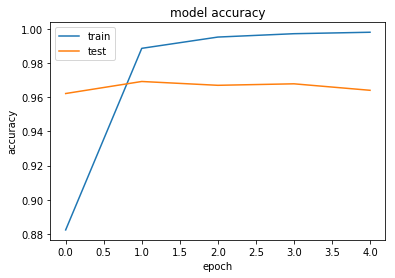

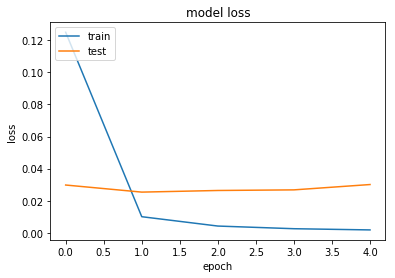

------------------------------Begin: test------------------------------
Test acc: 0.9388823086034241


In [40]:
plot_history(data)
y_pred = capsmodel.predict(testX, batch_size=100)
print('-'*30 + 'Begin: test' + '-'*30)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(testY_cat, 1))/testY_cat.shape[0])

In [ ]:
testPred = [ 3, 5, 3, 4, 7, 3, 9]
testPred = np.array(testPred / np.linalg.norm(testPred))
print(testPred)
testTrue = trainY_cat[0]
print(testTrue)

In [ ]:
#margin_loss( trainY_cat[0], testPred)
L = testTrue * np.square(np.maximum(0., 0.9 - testPred)) + 0.5 * (1 - testTrue) * np.square(np.maximum(0., testPred - 0.1))
print(L)
print(np.mean(np.sum(L, 0)))

In [ ]:
"""# compile the model
capsmodel.compile(optimizer=opt, #'adam',
              loss=[margin_loss, 'mse'],
              loss_weights=[1., lam_recon],
              metrics={'out_caps': 'accuracy'})

# train the model
data = capsmodel.fit( [trainX, trainY_cat], 
                      [trainY_cat, trainX], 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      #validation_data=[[devX], [devY_cat]], 
                      validation_data=[[devX, devY_cat], [devY_cat, devX]], 
                      callbacks=[log, tb, checkpoint], 
                      verbose=1)
"""

In [ ]:
trainX.shape
trainY.shape

In [ ]:
print(devX.shape)
print(devY.shape)
print(devY_cat.shape)

In [ ]:
trainY.shape